<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-forex/blob/main/ES_FX_Cap%C3%ADtulo_06_Gesti%C3%B3n_del_riesgo_del_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# Gestión del riesgo y optimización del portfolio


<br>

💰 Únete a la comunidad de [Discord](https://discord.gg/wXjNPAc5BH)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.com/gp/product/B09HG18CYL)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

# Importar ficheros de optimización de portfolio

In [3]:
ml_returns = pd.read_csv("ML.csv", index_col="time", parse_dates=True)

In [4]:
ta_returns = pd.read_csv("TA.csv", index_col="time", parse_dates=True).dropna()

# Optimización del portfolio

In [10]:
from scipy.optimize import minimize
def SR_criterion(weight, returns): 
  """ 
  ------------------------------------------------------------------------------
  | Output: El opuesto del ratio sortino que minimizaremos                     |
  ------------------------------------------------------------------------------
  | Inputs: -Weight (type ndarray numpy): Los pesos del portfolio              |
  |         -returns (type dataframe pandas): Retornos de los activos          |
  ------------------------------------------------------------------------------
  """
  pf_return = returns.values.dot(weight)
  mu = np.mean(pf_return) 
  sigma = np.std(pf_return[pf_return<0])
  Sortino = -mu/sigma
  return Sortino



# Calculamos el número de estrategias que tenemos
n = ml_returns.shape[1]

# Inicializamos los pesos
x0 = np.zeros(n)+(1/n) # x0 = [x_1, x_2, ..., x_n]

# Restricciones del problema de optimización
cons=({'type':'eq', 'fun':lambda x:sum(abs(x))-1}) # sum|x_i| - 1 =0


# Límites de las variables
Bounds = [(0.05,0.3) for i in range(0,n)]

# Resolvemos el problema de optimización
res_SR = minimize(SR_criterion, x0, method="SLSQP", args=(ml_returns.dropna()), bounds=Bounds, constraints=cons, options={'disp':False})

# Resultados de los cálculos
X_SR = res_SR.x

np.round(X_SR,3)

array([0.05, 0.3 , 0.05, 0.05, 0.05, 0.3 , 0.1 , 0.05, 0.05])

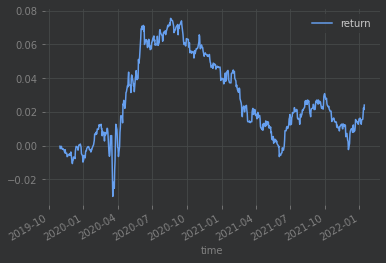

In [11]:
sr = np.multiply(ml_returns, X_SR).sum(axis=1)
sr = pd.DataFrame(sr, columns=["return"])
sr.cumsum().plot()

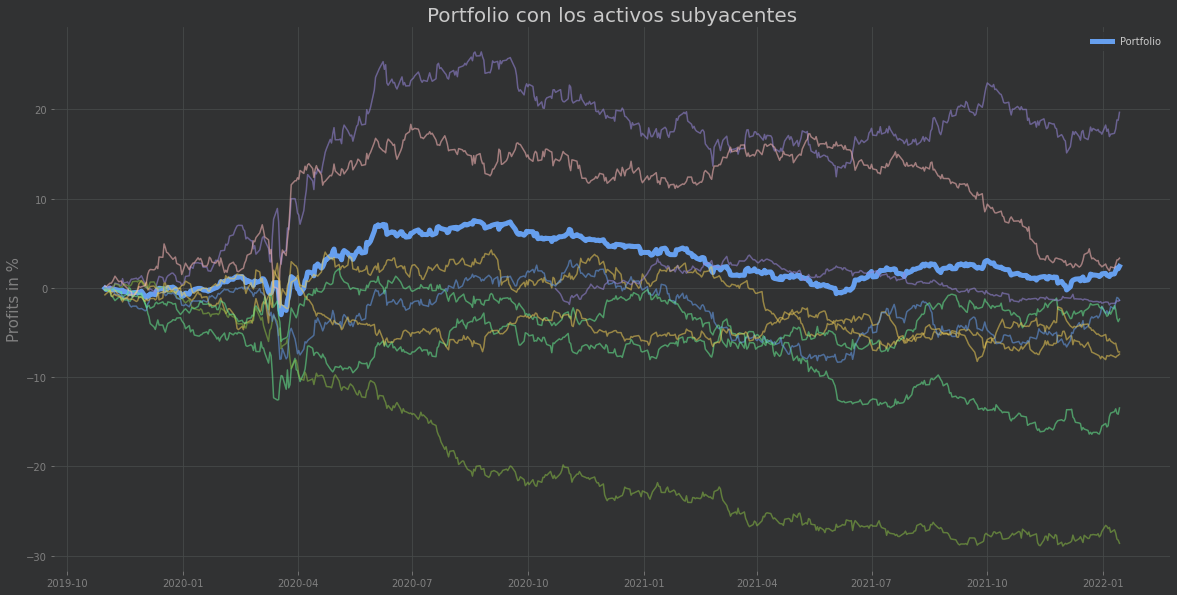

In [12]:
plt.figure(figsize=(20,10))
plt.plot(sr.cumsum()*100, linewidth=5, label="Portfolio")
plt.plot(ml_returns.cumsum()*100, alpha=0.55)

plt.title("Portfolio con los activos subyacentes", size=20)
plt.ylabel("Profits in %", size=15)

plt.legend()
plt.show()

# Ejemplo de gestión del riesgo

<p><img alt="Colaboratory logo"  src="https://www.quantreo.com/wp-content/uploads/2022/01/Capture-decran-2022-01-13-a-18.33.13.png" align="left" hspace="10px" vspace="0px"></p>


In [14]:
def drawdown_function(serie):

    # Calculamos la suma acumulada de los retornos
    cum = serie.dropna().cumsum() + 1

    # Calculamos el valor máximo de la suma acumulada en el periodo (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # Calculamos el drawdown
    drawdown = cum/running_max - 1
    return drawdown

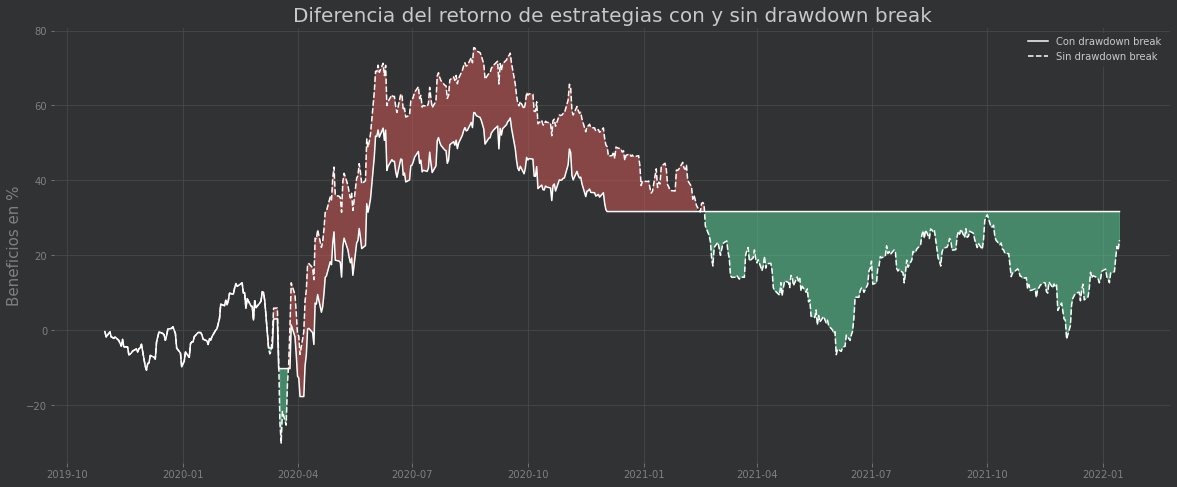

In [16]:
# Portfolio creation
leverage = 10
sr = np.multiply(ml_returns, X_SR).sum(axis=1)
ddb = pd.DataFrame(sr, columns=["return"])*leverage

# Drawdown computation
ddb["drawdown"] = drawdown_function(ddb["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
ddb.loc[ddb["drawdown"].shift(1)<-0.015*leverage, "return"] = 0


# Display
with_ddb = ddb["return"].cumsum()*100
without_ddb = sr.cumsum()*leverage*100

plt.figure(figsize=(20,8))
plt.plot(with_ddb, "-", color="white")
plt.plot(without_ddb,"--", color="white")

plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb<without_ddb, color= "#CE5757", alpha=0.55)
plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb>without_ddb, color= "#57CE95", alpha=0.55)

plt.legend(["Con drawdown break", "Sin drawdown break"])
plt.ylabel("Beneficios en %", size=15)
plt.title("Diferencia del retorno de estrategias con y sin drawdown break", size=20)

plt.show()

# Drawdown break individual


In [32]:
# Creamos un dataframe vacío
ddb_ret = pd.DataFrame()

ddb_threshold = 0.06
for name in ml_returns.columns:
  
  # Take the returns
  ret = ml_returns[[name]]
  
  # Rename
  ret.columns = ["return"]

  # Compute the drawdown
  ret["drawdown"] = drawdown_function(ret["return"])

  # Add the ddb
  ret.loc[ret["drawdown"].shift(1)<-ddb_threshold] = 0

  # Rename
  ret.columns = [name, "dd"]

  ddb_ret[name] = ret[name]

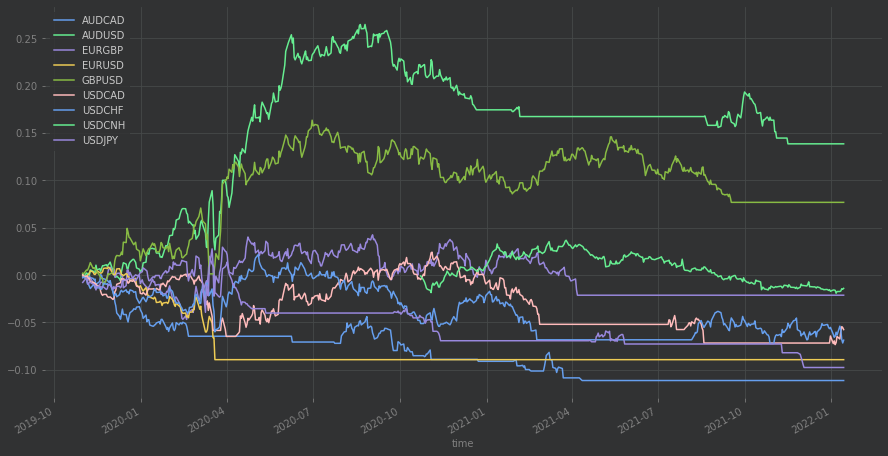

In [33]:
ddb_ret.cumsum(axis=0).plot(figsize=(15,8))

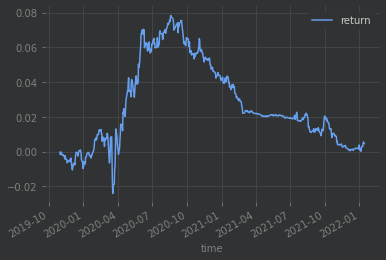

In [34]:
# Plot DDB returns
sr = np.multiply(ddb_ret, X_SR).sum(axis=1)
sr = pd.DataFrame(sr, columns=["return"])
sr.cumsum().plot()

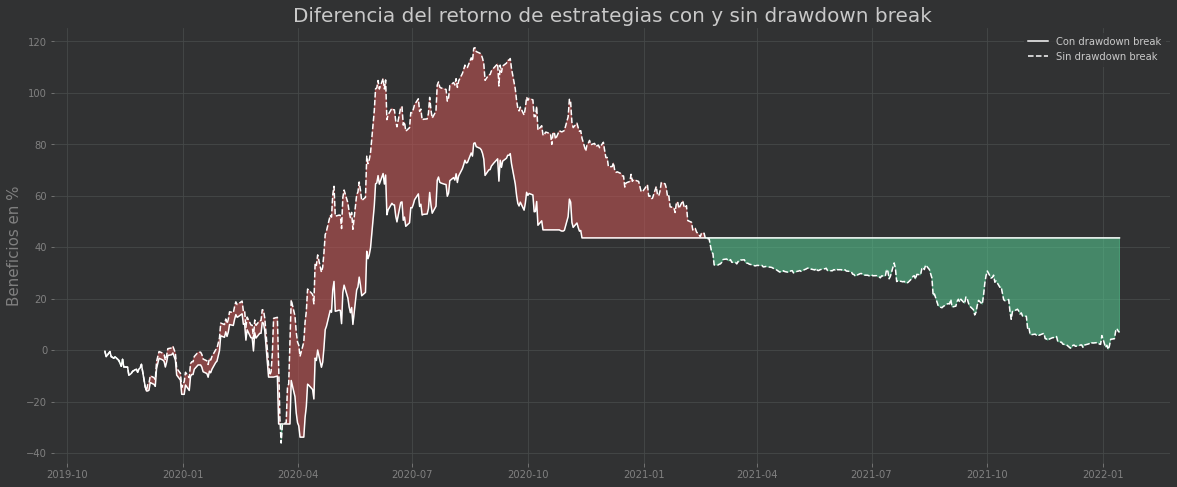

In [35]:
# Portfolio creation
leverage = 15
sr = np.multiply(ddb_ret, X_SR).sum(axis=1)
ddb = pd.DataFrame(sr, columns=["return"])*leverage

# Drawdown computation
ddb["drawdown"] = drawdown_function(ddb["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
ddb.loc[ddb["drawdown"].shift(1)<-0.01 * leverage, "return"] = 0


with_ddb = ddb["return"].cumsum()*100
without_ddb = sr.cumsum()*leverage*100

plt.figure(figsize=(20,8))
plt.plot(with_ddb, "-", color="white")
plt.plot(without_ddb,"--", color="white")

plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb<without_ddb, color= "#CE5757", alpha=0.55)
plt.fill_between(with_ddb.index, with_ddb, without_ddb,with_ddb>without_ddb, color= "#57CE95", alpha=0.55)

plt.legend(["Con drawdown break", "Sin drawdown break"])
plt.ylabel("Beneficios en %", size=15)
plt.title("Diferencia del retorno de estrategias con y sin drawdown break", size=20)

plt.show()